# Noise study, FFT

In this notebook I look the FFT of the noise, and try to look for noise correlated to the trigger. The original idea was to see how the noise affects the risetime calculation

In [ ]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [2]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/Calibrations_Xe_Run11b.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/Channel_Map_Xe_Run29.csv'
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile(run_parameters_file)
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
waveform_length = analysis_config.run_parameters['Waveform Length [samples]']
path_to_reduced = '/p/lustre1/jacopod/29th/analysis_2500ns/20200212_RecirculationOff'

In [3]:
start_time = time.time()
df = pd.read_hdf(path_to_reduced + '/reduced_added.h5')
print('dataframe with {} events loaded in {:.1f}s'.format(df.shape[0],time.time() - start_time))

dataframe with 1026478 events loaded in 86.9s


In [4]:
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStrip X15 Baseline
TileStrip X15 Baseline RMS
Til

In [25]:
event_to_concatenate = 100
rise_time10 = (df['TileStrip X14 T90'] - df['TileStrip X14 T10'])*sampling_time
selection_index_noise  = df[df['TotalTileEnergy']<20].index
#selection_index_signal = df[df['TotalTileEnergy']>1000].index
noise_idx = selection_index_noise[:event_to_concatenate]
#signal_idx = selection_index_signal[:event_to_concatenate]

In [6]:
analysis_config.GetChannelMapFromFile(channel_map_file)

In [15]:
skip = True
def wfm_dict(event_idx, smoothing_windows_us,fft_return=False):
    dct = {}
    if fft_return:
        fft_dct = {}
        fft_freq = np.fft.rfftfreq(int(waveform_length),1.e-1/waveform_length)
        fft_dct['freq'] = fft_freq
    for i in event_idx:
        event = Waveform.Event(path_to_reduced + '/reduced_added.h5',\
                               '/p/lustre1/jacopod/29th/20200212_RecirculationOff/tier1/',i,\
                           run_parameters_file,\
                           calibrations_file,\
                           channel_map_file)

        event.smooth(smoothing_windows_us)
        #plot = event.plot_event(risetime=True)
        #plot.show()
        for j in range(analysis_config.GetNumberOfChannels()):
            ch_type = analysis_config.GetChannelTypeForSoftwareChannel(j)
            ch_name = analysis_config.GetChannelNameForSoftwareChannel(j)
            mean_waveform = np.mean(event.waveform[ch_name].data)
            baseline = df['{} {} Baseline'.format(ch_type,ch_name)][i]
            if skip and np.abs(mean_waveform-baseline)> 2*df['{} {} Baseline RMS'.format(ch_type,ch_name)][i]:
                print('skipping event {} on channel {}, baseline not stable'.format(i,ch_name))
                continue
            wfm = event.waveform[ch_name].data - baseline
            if fft_return:
                fft_wfm = np.fft.rfft(wfm).real
            try:
                dct[ch_name] = np.vstack((dct[ch_name],wfm))
                if fft_return:
                    fft_dct[ch_name] = np.vstack((fft_dct[ch_name],fft_wfm))
            except KeyError:
                dct[ch_name] = wfm.reshape(1,int(waveform_length))
                if fft_return:
                    fft_dct[ch_name] = fft_wfm.reshape(1,len(fft_freq))
    if fft_return:
        return dct, fft_dct
    
    return dct

In [18]:
smoothing_windows_us = 2.5
wfm_noise, fft_noise = wfm_dict(noise_idx, smoothing_windows_us,True)
wfm_signal, fft_signal = wfm_dict(signal_idx, smoothing_windows_us,True)

skipping event 26 on channel X1-12, baseline not stable
skipping event 26 on channel X13, baseline not stable
skipping event 26 on channel X14, baseline not stable
skipping event 26 on channel X15, baseline not stable
skipping event 26 on channel X16, baseline not stable
skipping event 26 on channel X17, baseline not stable
skipping event 26 on channel X18, baseline not stable
skipping event 26 on channel X19, baseline not stable
skipping event 26 on channel X20, baseline not stable
skipping event 26 on channel X21, baseline not stable
skipping event 26 on channel X22, baseline not stable
skipping event 26 on channel X23/24, baseline not stable
skipping event 26 on channel X25/26, baseline not stable
skipping event 26 on channel X27/28, baseline not stable
skipping event 26 on channel X29/30, baseline not stable
skipping event 26 on channel 1-3, baseline not stable
skipping event 26 on channel Y1-10, baseline not stable
skipping event 26 on channel Y11, baseline not stable
skipping eve

skipping event 692 on channel X1-12, baseline not stable
skipping event 692 on channel X13, baseline not stable
skipping event 692 on channel X14, baseline not stable
skipping event 692 on channel X15, baseline not stable
skipping event 692 on channel X16, baseline not stable
skipping event 692 on channel X17, baseline not stable
skipping event 692 on channel X18, baseline not stable
skipping event 692 on channel X19, baseline not stable
skipping event 692 on channel X20, baseline not stable
skipping event 692 on channel X21, baseline not stable
skipping event 692 on channel X22, baseline not stable
skipping event 692 on channel X23/24, baseline not stable
skipping event 692 on channel X25/26, baseline not stable
skipping event 692 on channel X27/28, baseline not stable
skipping event 692 on channel X29/30, baseline not stable
skipping event 692 on channel Y1-10, baseline not stable
skipping event 692 on channel Y11, baseline not stable
skipping event 692 on channel Y12, baseline not s

skipping event 765 on channel X1-12, baseline not stable
skipping event 765 on channel X14, baseline not stable
skipping event 765 on channel X15, baseline not stable
skipping event 765 on channel X16, baseline not stable
skipping event 765 on channel X17, baseline not stable
skipping event 765 on channel X18, baseline not stable
skipping event 765 on channel X20, baseline not stable
skipping event 765 on channel X21, baseline not stable
skipping event 765 on channel X22, baseline not stable
skipping event 765 on channel X23/24, baseline not stable
skipping event 765 on channel X27/28, baseline not stable
skipping event 765 on channel X29/30, baseline not stable
skipping event 765 on channel 1-3, baseline not stable
skipping event 765 on channel Y1-10, baseline not stable
skipping event 765 on channel Y11, baseline not stable
skipping event 765 on channel Y12, baseline not stable
skipping event 765 on channel Y13, baseline not stable
skipping event 765 on channel Y14, baseline not stab

ValueError: too many values to unpack (expected 2)

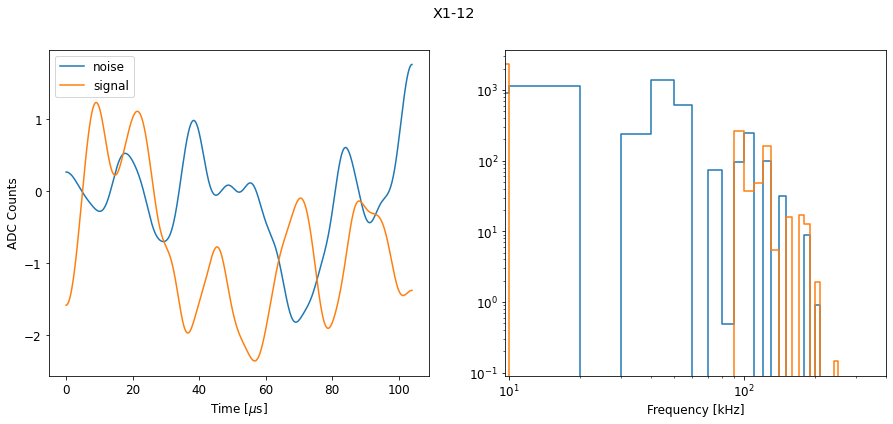

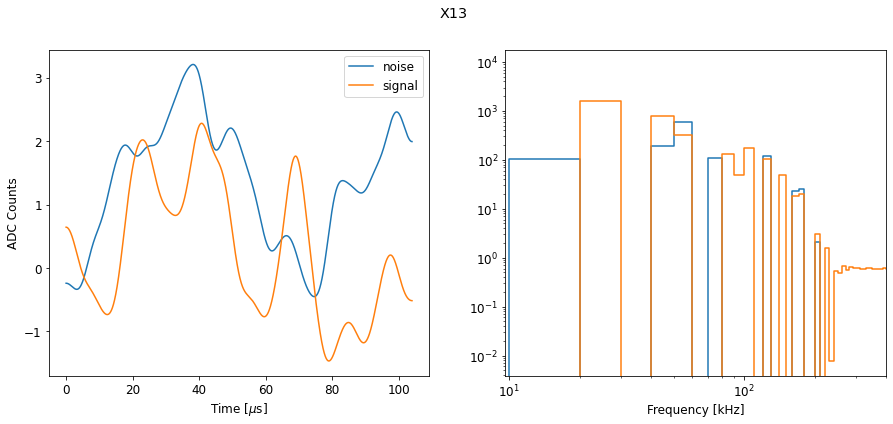

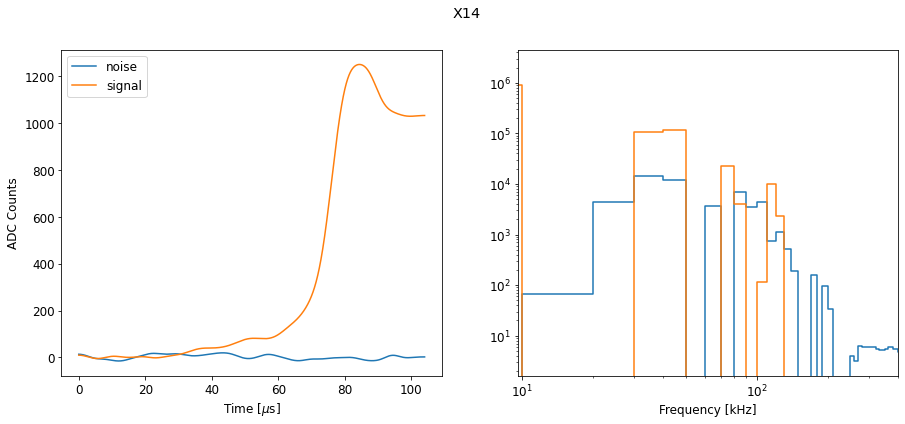

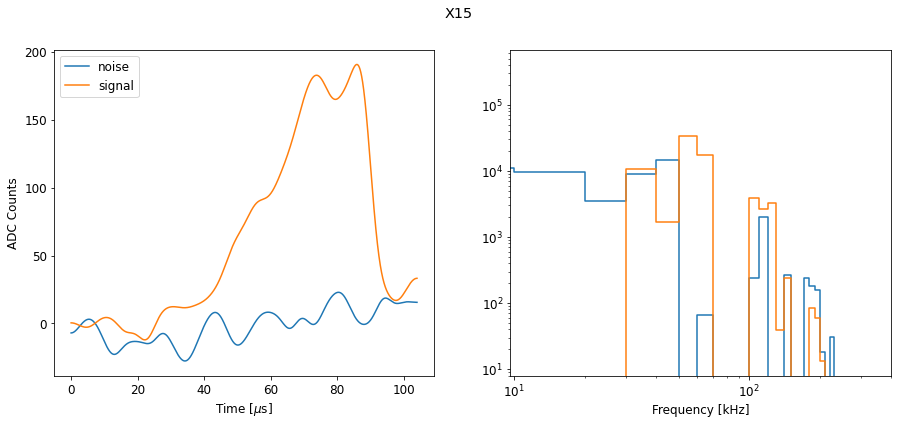

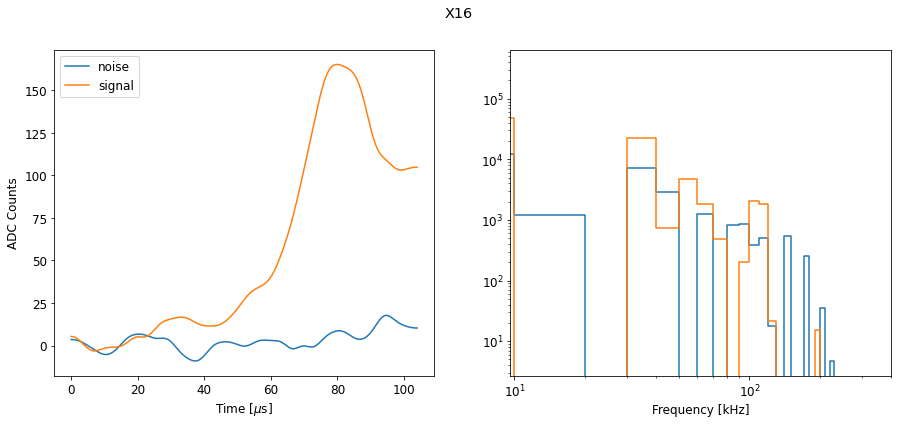

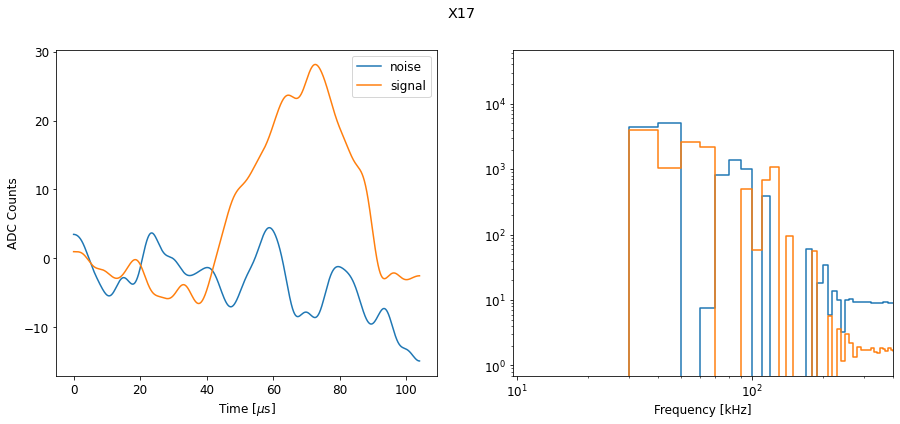

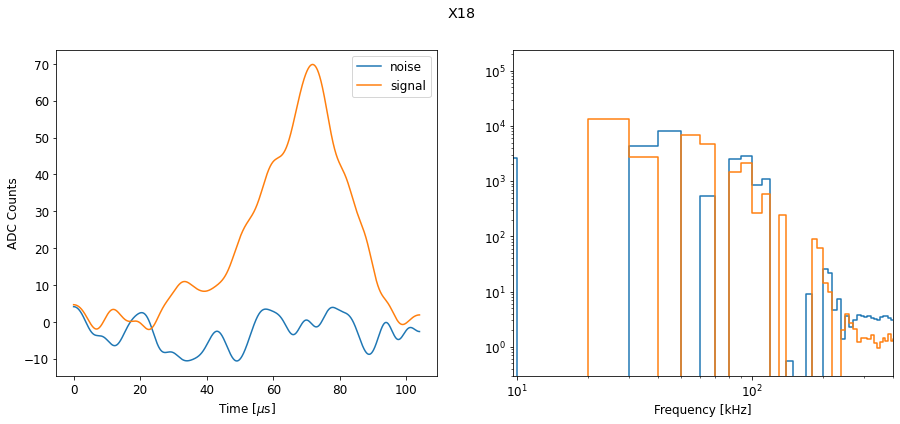

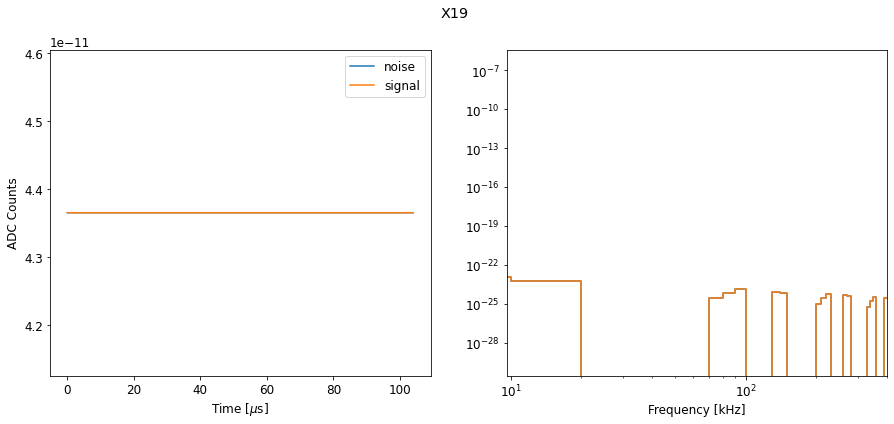

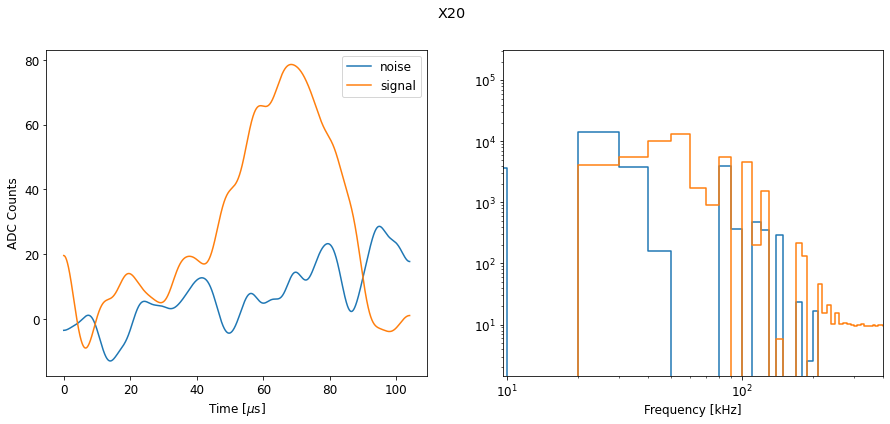

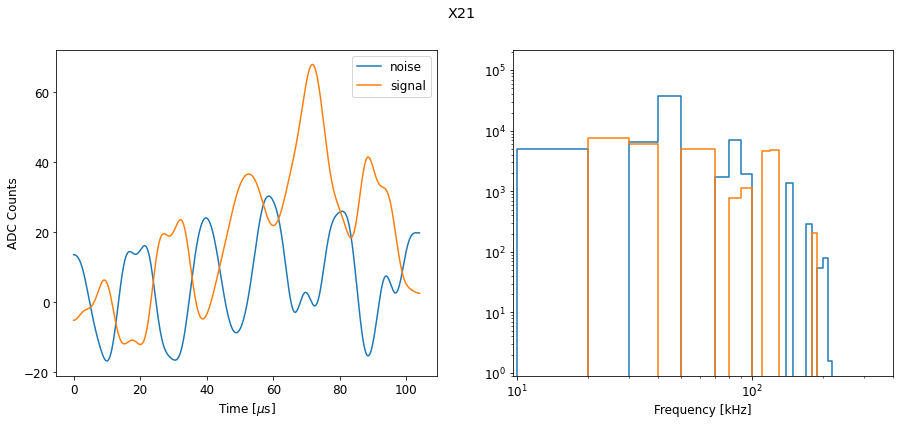

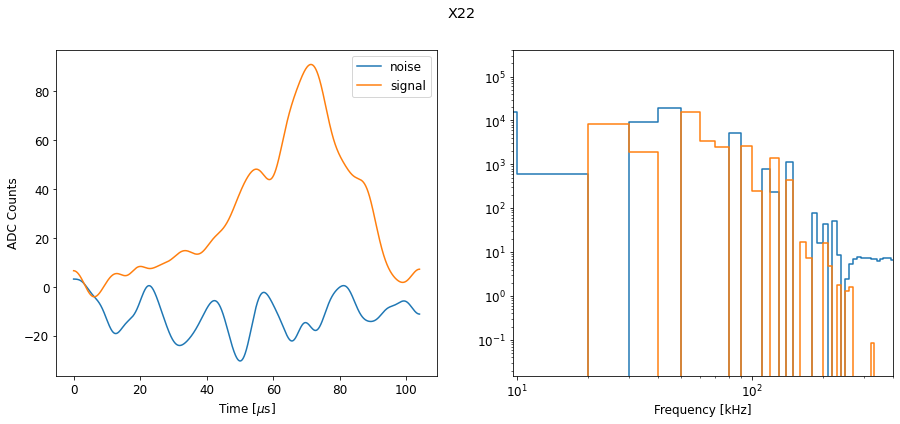

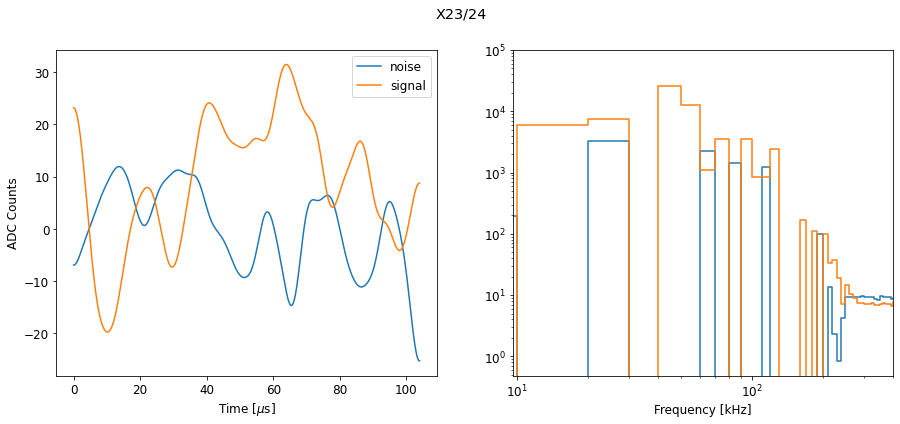

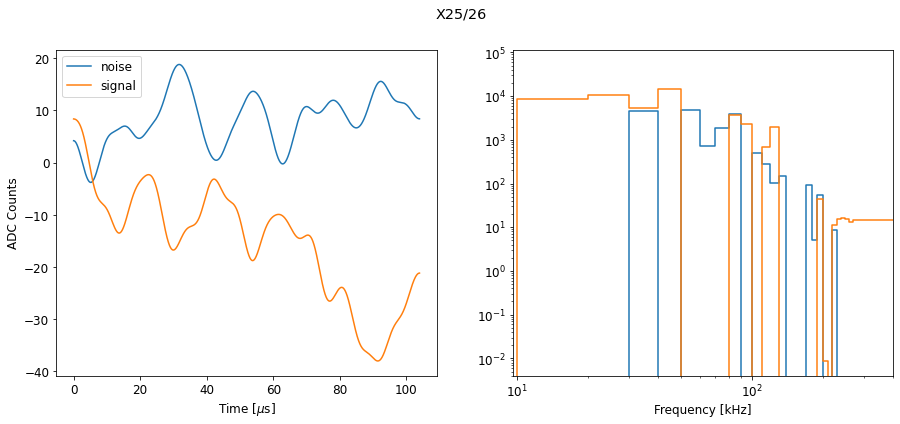

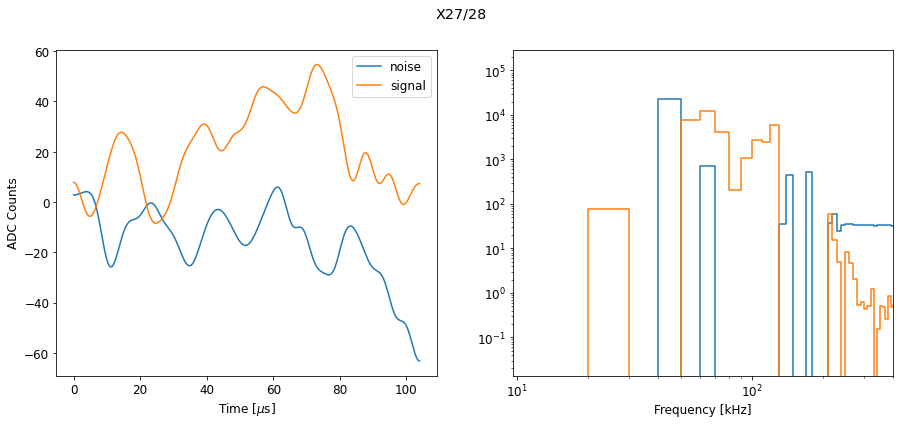

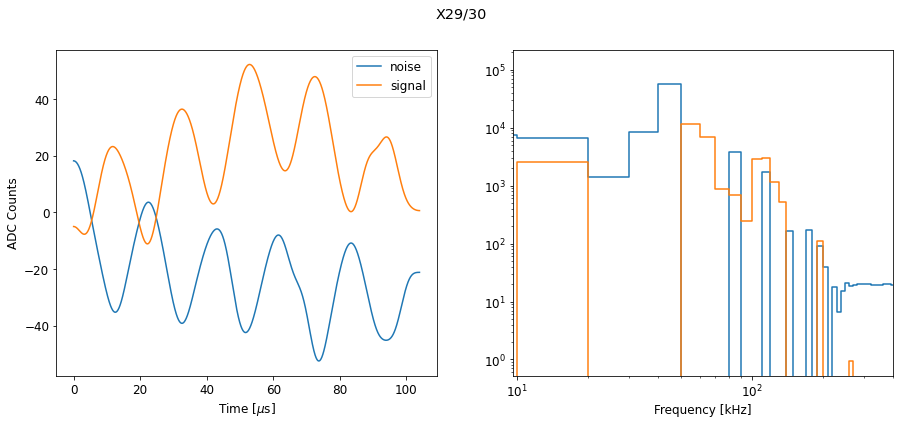

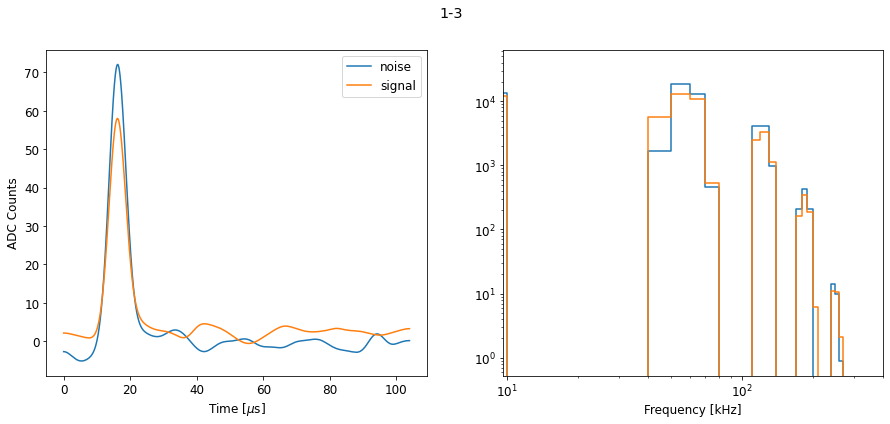

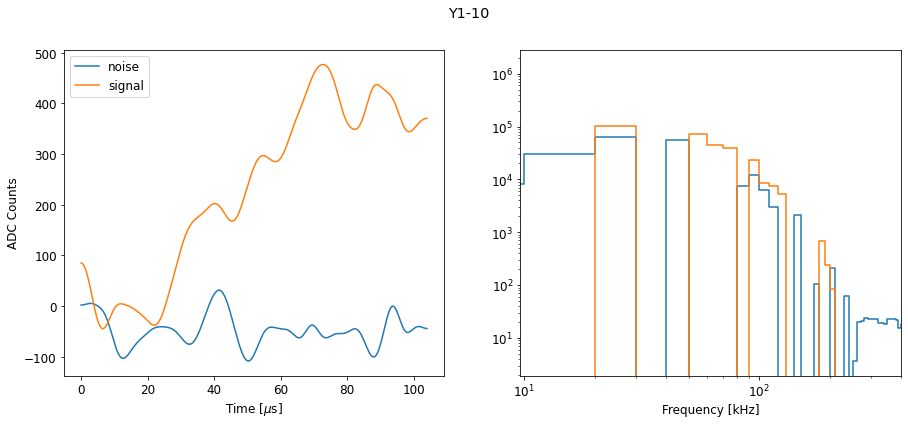

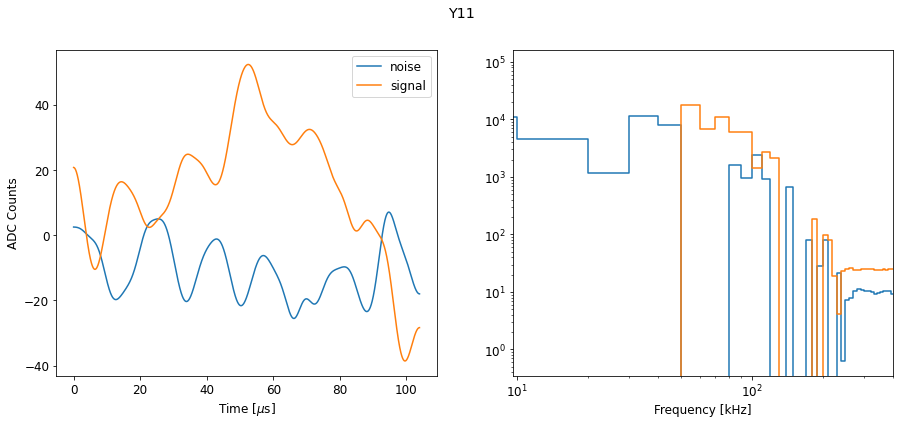

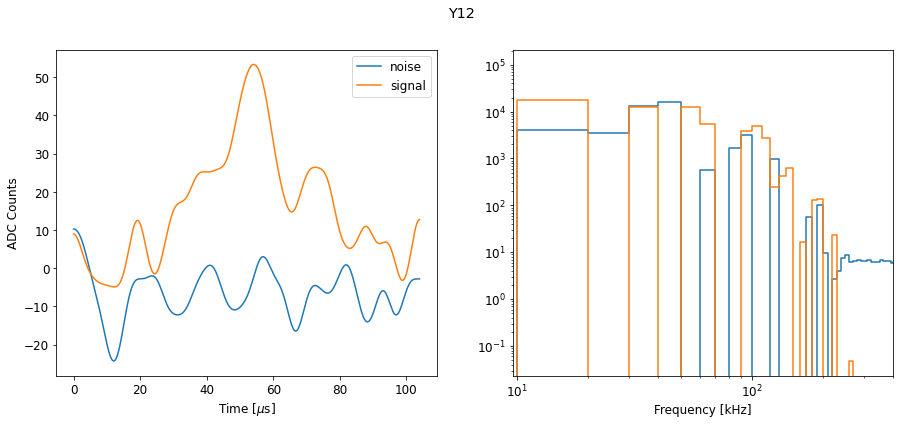

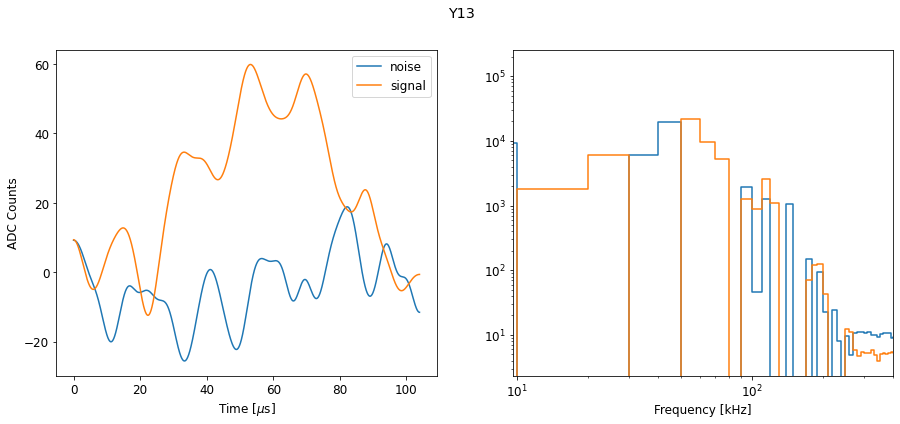

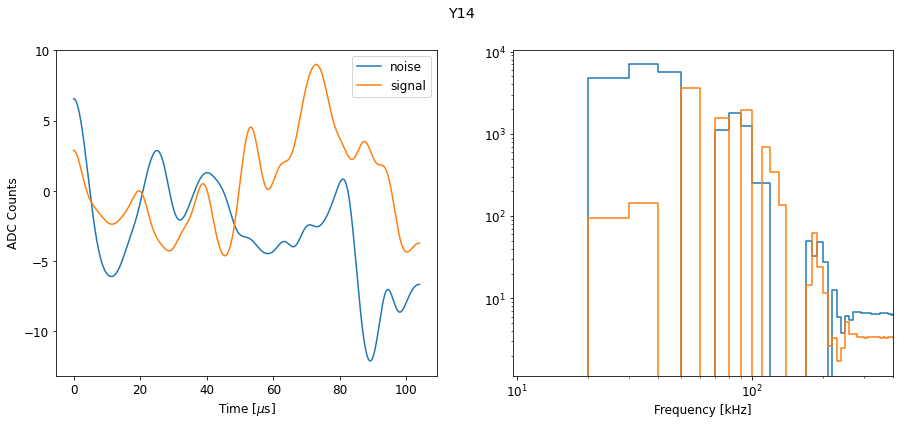

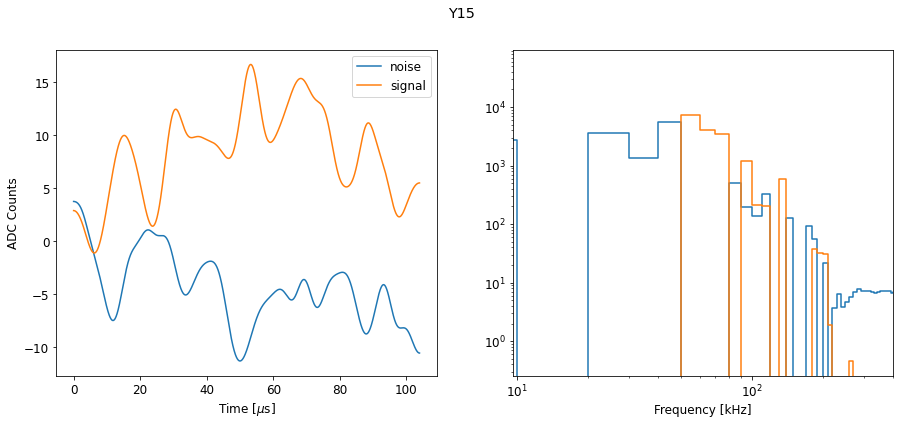

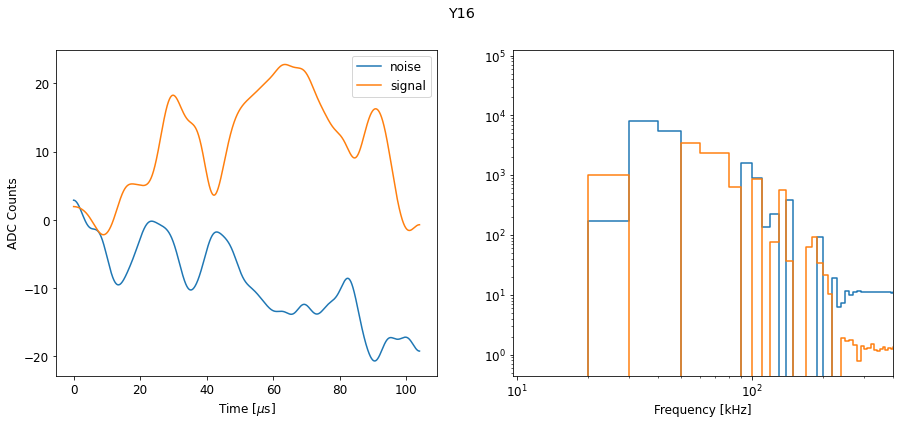

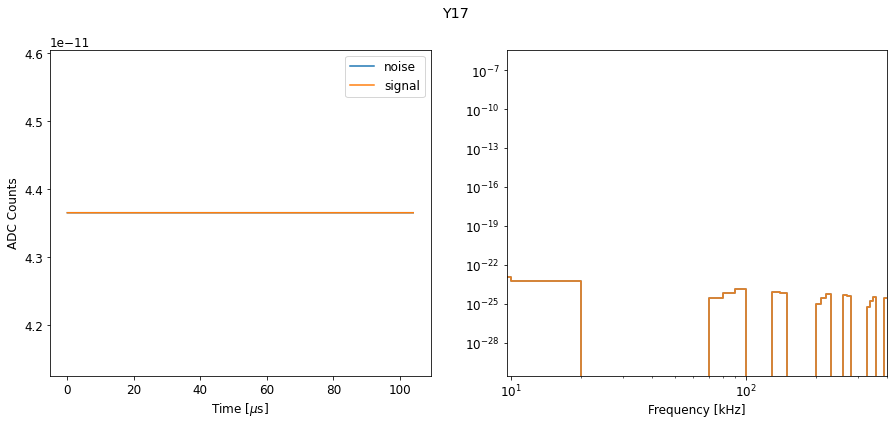

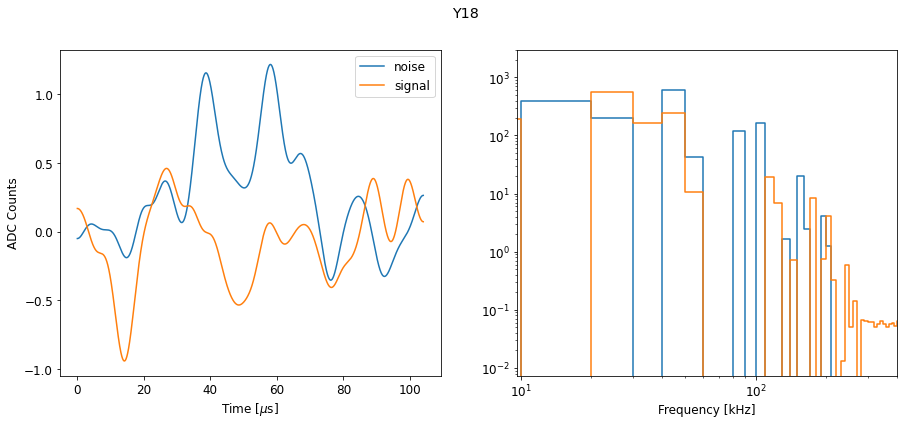

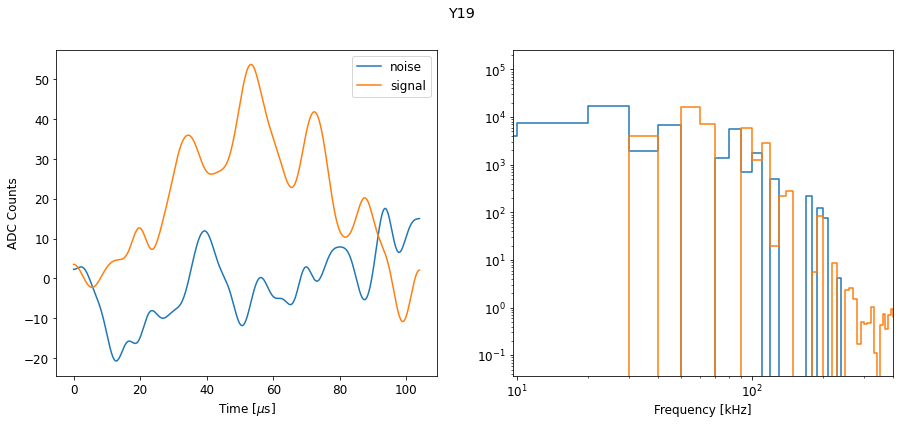

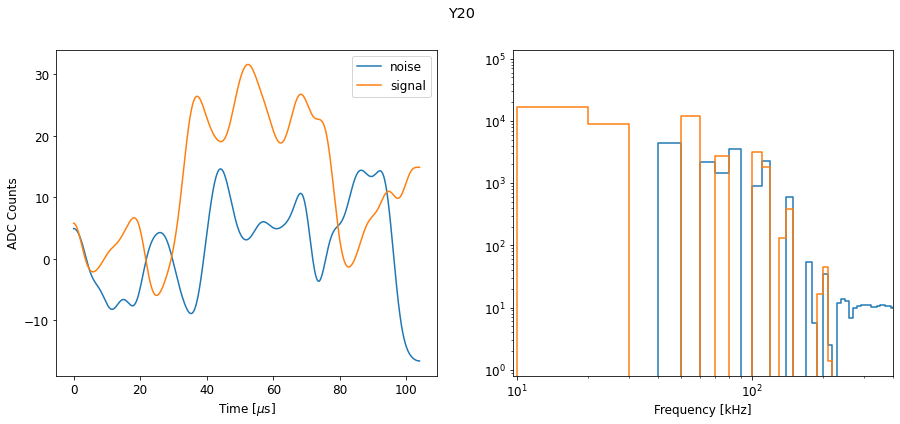

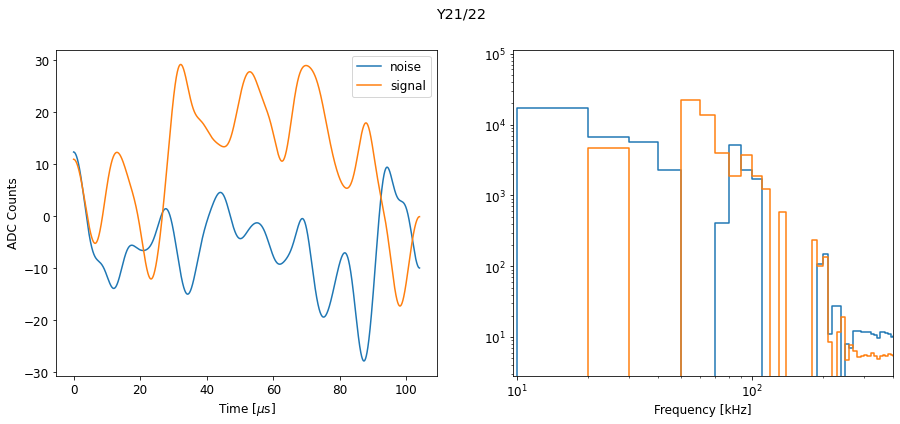

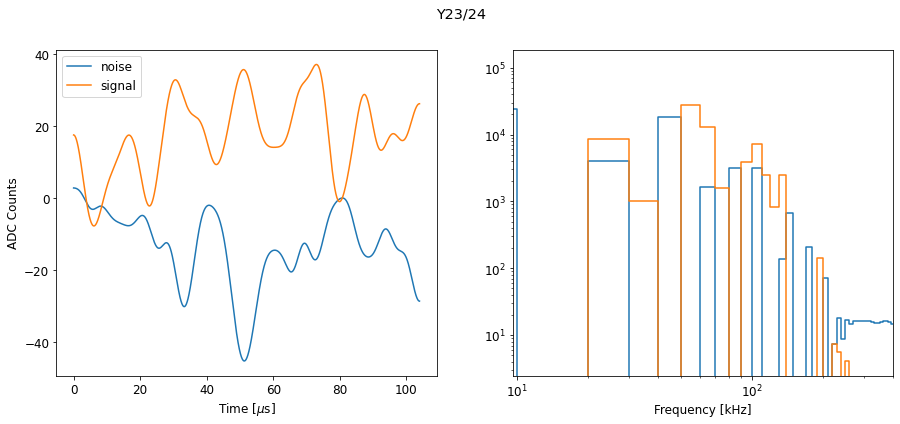

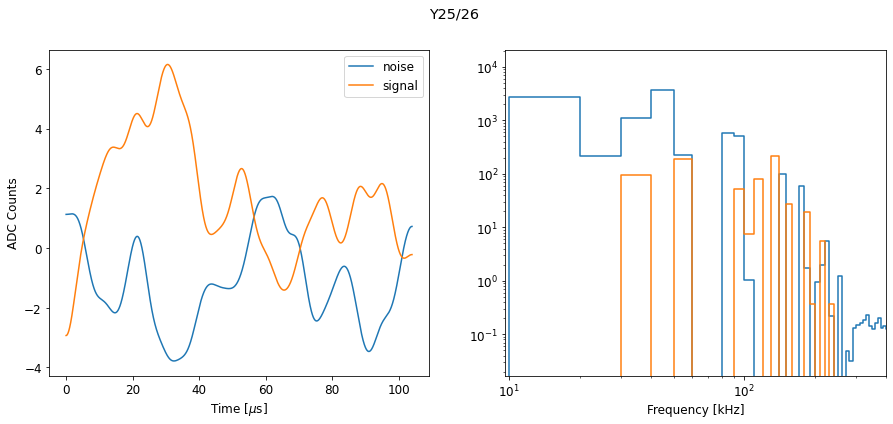

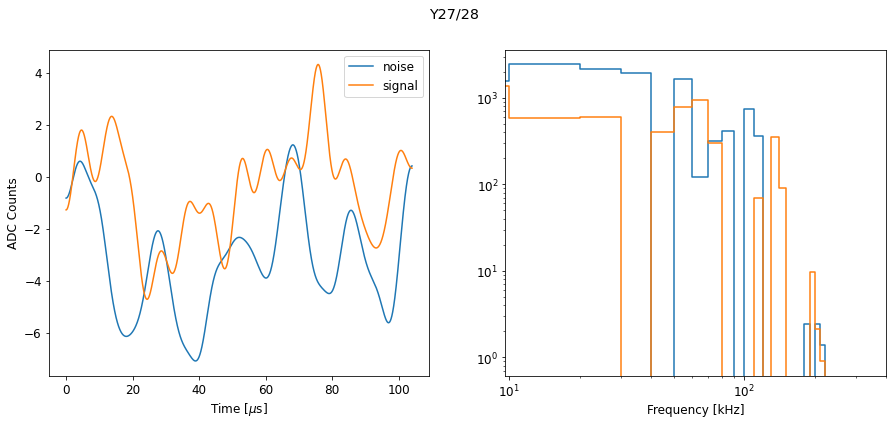

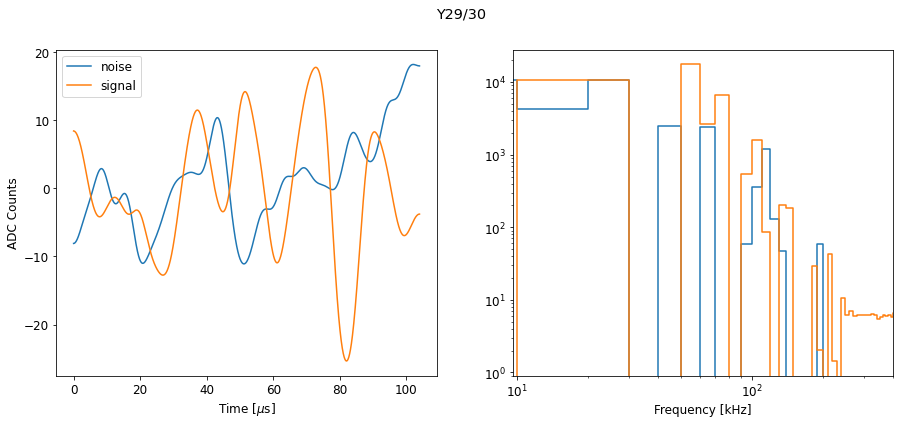

In [43]:
for k in wfm_signal:
    fig,ax = plt.subplots(1,2,figsize=(15,6))
    ax[0].plot(np.arange(waveform_length)*sampling_time,wfm_noise[k][0],label='noise')
    ax[0].plot(np.arange(waveform_length)*sampling_time,wfm_signal[k][0],label='signal')
    ax[0].legend()
    ax[0].set_xlabel('Time [$\mu$s]')
    ax[0].set_ylabel('ADC Counts')
    ax[1].step(fft_noise['freq'],fft_noise[k][0])
    ax[1].step(fft_signal['freq'],fft_signal[k][0])
    ax[1].set_xlim(1.e3/(waveform_length*sampling_time),1.e3/smoothing_windows_us)
    ax[1].set_xlabel('Frequency [kHz]')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    fig.suptitle(k)
    plt.show()

In [26]:
smoothing_windows_us = 2.5
wfm_noise_25 = wfm_dict(noise_idx, smoothing_windows_us,False)

skipping event 26 on channel X1-12, baseline not stable
skipping event 26 on channel X13, baseline not stable
skipping event 26 on channel X14, baseline not stable
skipping event 26 on channel X15, baseline not stable
skipping event 26 on channel X16, baseline not stable
skipping event 26 on channel X17, baseline not stable
skipping event 26 on channel X18, baseline not stable
skipping event 26 on channel X20, baseline not stable
skipping event 26 on channel X21, baseline not stable
skipping event 26 on channel X22, baseline not stable
skipping event 26 on channel X23/24, baseline not stable
skipping event 26 on channel X25/26, baseline not stable
skipping event 26 on channel X27/28, baseline not stable
skipping event 26 on channel X29/30, baseline not stable
skipping event 26 on channel 1-3, baseline not stable
skipping event 26 on channel Y1-10, baseline not stable
skipping event 26 on channel Y11, baseline not stable
skipping event 26 on channel Y12, baseline not stable
skipping eve

skipping event 721 on channel X1-12, baseline not stable
skipping event 721 on channel X13, baseline not stable
skipping event 721 on channel X14, baseline not stable
skipping event 721 on channel X15, baseline not stable
skipping event 721 on channel X16, baseline not stable
skipping event 721 on channel X17, baseline not stable
skipping event 721 on channel X18, baseline not stable
skipping event 721 on channel X19, baseline not stable
skipping event 721 on channel X20, baseline not stable
skipping event 721 on channel X21, baseline not stable
skipping event 721 on channel X22, baseline not stable
skipping event 721 on channel X23/24, baseline not stable
skipping event 721 on channel X25/26, baseline not stable
skipping event 721 on channel X27/28, baseline not stable
skipping event 721 on channel X29/30, baseline not stable
skipping event 721 on channel Y1-10, baseline not stable
skipping event 721 on channel Y11, baseline not stable
skipping event 721 on channel Y12, baseline not s

skipping event 818 on channel X1-12, baseline not stable
skipping event 818 on channel X13, baseline not stable
skipping event 818 on channel X14, baseline not stable
skipping event 818 on channel X15, baseline not stable
skipping event 818 on channel X16, baseline not stable
skipping event 818 on channel X17, baseline not stable
skipping event 818 on channel X18, baseline not stable
skipping event 818 on channel X20, baseline not stable
skipping event 818 on channel X21, baseline not stable
skipping event 818 on channel X22, baseline not stable
skipping event 818 on channel X23/24, baseline not stable
skipping event 818 on channel X27/28, baseline not stable
skipping event 818 on channel X29/30, baseline not stable
skipping event 818 on channel Y1-10, baseline not stable
skipping event 818 on channel Y11, baseline not stable
skipping event 818 on channel Y12, baseline not stable
skipping event 818 on channel Y13, baseline not stable
skipping event 818 on channel Y14, baseline not stab

skipping event 1098 on channel X1-12, baseline not stable
skipping event 1098 on channel X14, baseline not stable
skipping event 1098 on channel X16, baseline not stable
skipping event 1098 on channel X18, baseline not stable
skipping event 1098 on channel X20, baseline not stable
skipping event 1098 on channel X23/24, baseline not stable
skipping event 1098 on channel X29/30, baseline not stable
skipping event 1098 on channel Y1-10, baseline not stable
skipping event 1098 on channel Y13, baseline not stable
skipping event 1098 on channel Y15, baseline not stable
skipping event 1098 on channel Y21/22, baseline not stable
skipping event 1098 on channel Y23/24, baseline not stable
skipping event 1195 on channel X1-12, baseline not stable
skipping event 1195 on channel X13, baseline not stable
skipping event 1195 on channel X14, baseline not stable
skipping event 1195 on channel X15, baseline not stable
skipping event 1195 on channel X16, baseline not stable
skipping event 1195 on channel

skipping event 1359 on channel X1-12, baseline not stable
skipping event 1359 on channel X13, baseline not stable
skipping event 1359 on channel X14, baseline not stable
skipping event 1359 on channel X15, baseline not stable
skipping event 1359 on channel X16, baseline not stable
skipping event 1359 on channel X17, baseline not stable
skipping event 1359 on channel X18, baseline not stable
skipping event 1359 on channel X20, baseline not stable
skipping event 1359 on channel X21, baseline not stable
skipping event 1359 on channel X22, baseline not stable
skipping event 1359 on channel X23/24, baseline not stable
skipping event 1359 on channel X27/28, baseline not stable
skipping event 1359 on channel X29/30, baseline not stable
skipping event 1359 on channel Y1-10, baseline not stable
skipping event 1359 on channel Y11, baseline not stable
skipping event 1359 on channel Y12, baseline not stable
skipping event 1359 on channel Y13, baseline not stable
skipping event 1359 on channel Y14,

skipping event 1632 on channel X1-12, baseline not stable
skipping event 1632 on channel X13, baseline not stable
skipping event 1632 on channel X14, baseline not stable
skipping event 1632 on channel X15, baseline not stable
skipping event 1632 on channel X16, baseline not stable
skipping event 1632 on channel X17, baseline not stable
skipping event 1632 on channel X18, baseline not stable
skipping event 1632 on channel X19, baseline not stable
skipping event 1632 on channel X20, baseline not stable
skipping event 1632 on channel 1-3, baseline not stable
skipping event 1632 on channel Y1-10, baseline not stable
skipping event 1632 on channel Y11, baseline not stable
skipping event 1632 on channel Y13, baseline not stable
skipping event 1632 on channel Y14, baseline not stable
skipping event 1632 on channel Y15, baseline not stable
skipping event 1632 on channel Y16, baseline not stable
skipping event 1632 on channel Y18, baseline not stable
skipping event 1632 on channel Y19, baseline

skipping event 1910 on channel X1-12, baseline not stable
skipping event 1910 on channel X13, baseline not stable
skipping event 1910 on channel X22, baseline not stable
skipping event 1910 on channel Y20, baseline not stable
skipping event 1910 on channel Y27/28, baseline not stable
skipping event 1949 on channel X19, baseline not stable
skipping event 1949 on channel X22, baseline not stable
skipping event 1949 on channel X27/28, baseline not stable
skipping event 1949 on channel X29/30, baseline not stable
skipping event 2051 on channel X1-12, baseline not stable
skipping event 2051 on channel X14, baseline not stable
skipping event 2051 on channel X15, baseline not stable
skipping event 2051 on channel X16, baseline not stable
skipping event 2051 on channel X17, baseline not stable
skipping event 2051 on channel X18, baseline not stable
skipping event 2051 on channel X19, baseline not stable
skipping event 2051 on channel X20, baseline not stable
skipping event 2051 on channel X21,

skipping event 2442 on channel X1-12, baseline not stable
skipping event 2442 on channel X13, baseline not stable
skipping event 2442 on channel X14, baseline not stable
skipping event 2442 on channel X15, baseline not stable
skipping event 2442 on channel X16, baseline not stable
skipping event 2442 on channel X17, baseline not stable
skipping event 2442 on channel X18, baseline not stable
skipping event 2442 on channel X19, baseline not stable
skipping event 2442 on channel X20, baseline not stable
skipping event 2442 on channel X21, baseline not stable
skipping event 2442 on channel X22, baseline not stable
skipping event 2442 on channel X23/24, baseline not stable
skipping event 2442 on channel X27/28, baseline not stable
skipping event 2442 on channel X29/30, baseline not stable
skipping event 2442 on channel Y1-10, baseline not stable
skipping event 2442 on channel Y11, baseline not stable
skipping event 2442 on channel Y12, baseline not stable
skipping event 2442 on channel Y13,

skipping event 2533 on channel X1-12, baseline not stable
skipping event 2533 on channel X13, baseline not stable
skipping event 2533 on channel X15, baseline not stable
skipping event 2533 on channel X17, baseline not stable
skipping event 2533 on channel X18, baseline not stable
skipping event 2533 on channel X19, baseline not stable
skipping event 2533 on channel X21, baseline not stable
skipping event 2533 on channel X27/28, baseline not stable
skipping event 2533 on channel Y1-10, baseline not stable
skipping event 2533 on channel Y11, baseline not stable
skipping event 2533 on channel Y13, baseline not stable
skipping event 2533 on channel Y14, baseline not stable
skipping event 2533 on channel Y16, baseline not stable
skipping event 2533 on channel Y18, baseline not stable
skipping event 2533 on channel Y20, baseline not stable
skipping event 2533 on channel Y21/22, baseline not stable
skipping event 2533 on channel Y23/24, baseline not stable
skipping event 2533 on channel Y25/

skipping event 2736 on channel X13, baseline not stable
skipping event 2736 on channel X17, baseline not stable
skipping event 2736 on channel X18, baseline not stable
skipping event 2736 on channel X20, baseline not stable
skipping event 2736 on channel X21, baseline not stable
skipping event 2736 on channel X22, baseline not stable
skipping event 2736 on channel Y1-10, baseline not stable
skipping event 2736 on channel Y14, baseline not stable
skipping event 2736 on channel Y17, baseline not stable
skipping event 2736 on channel Y18, baseline not stable
skipping event 2736 on channel Y19, baseline not stable
skipping event 2736 on channel Y21/22, baseline not stable
skipping event 2736 on channel Y25/26, baseline not stable
skipping event 2767 on channel X1-12, baseline not stable
skipping event 2767 on channel X13, baseline not stable
skipping event 2767 on channel X16, baseline not stable
skipping event 2767 on channel X19, baseline not stable
skipping event 2767 on channel X20, ba

skipping event 3259 on channel X1-12, baseline not stable
skipping event 3259 on channel X13, baseline not stable
skipping event 3259 on channel X14, baseline not stable
skipping event 3259 on channel X15, baseline not stable
skipping event 3259 on channel X16, baseline not stable
skipping event 3259 on channel X18, baseline not stable
skipping event 3259 on channel X19, baseline not stable
skipping event 3259 on channel X20, baseline not stable
skipping event 3259 on channel X22, baseline not stable
skipping event 3259 on channel X23/24, baseline not stable
skipping event 3259 on channel X27/28, baseline not stable
skipping event 3259 on channel X29/30, baseline not stable
skipping event 3259 on channel Y1-10, baseline not stable
skipping event 3259 on channel Y11, baseline not stable
skipping event 3259 on channel Y12, baseline not stable
skipping event 3259 on channel Y13, baseline not stable
skipping event 3259 on channel Y14, baseline not stable
skipping event 3259 on channel Y15,

skipping event 3540 on channel X1-12, baseline not stable
skipping event 3540 on channel X14, baseline not stable
skipping event 3540 on channel X15, baseline not stable
skipping event 3540 on channel X16, baseline not stable
skipping event 3540 on channel X17, baseline not stable
skipping event 3540 on channel X18, baseline not stable
skipping event 3540 on channel X19, baseline not stable
skipping event 3540 on channel X20, baseline not stable
skipping event 3540 on channel X21, baseline not stable
skipping event 3540 on channel X22, baseline not stable
skipping event 3540 on channel X23/24, baseline not stable
skipping event 3540 on channel X27/28, baseline not stable
skipping event 3540 on channel X29/30, baseline not stable
skipping event 3540 on channel Y1-10, baseline not stable
skipping event 3540 on channel Y11, baseline not stable
skipping event 3540 on channel Y12, baseline not stable
skipping event 3540 on channel Y13, baseline not stable
skipping event 3540 on channel Y14,

skipping event 3664 on channel X1-12, baseline not stable
skipping event 3664 on channel X14, baseline not stable
skipping event 3664 on channel X15, baseline not stable
skipping event 3664 on channel X16, baseline not stable
skipping event 3664 on channel X17, baseline not stable
skipping event 3664 on channel X18, baseline not stable
skipping event 3664 on channel X19, baseline not stable
skipping event 3664 on channel X20, baseline not stable
skipping event 3664 on channel X21, baseline not stable
skipping event 3664 on channel X22, baseline not stable
skipping event 3664 on channel X23/24, baseline not stable
skipping event 3664 on channel X27/28, baseline not stable
skipping event 3664 on channel X29/30, baseline not stable
skipping event 3664 on channel Y1-10, baseline not stable
skipping event 3664 on channel Y11, baseline not stable
skipping event 3664 on channel Y12, baseline not stable
skipping event 3664 on channel Y13, baseline not stable
skipping event 3664 on channel Y14,

skipping event 3984 on channel X1-12, baseline not stable
skipping event 3984 on channel X14, baseline not stable
skipping event 3984 on channel X15, baseline not stable
skipping event 3984 on channel X16, baseline not stable
skipping event 3984 on channel X17, baseline not stable
skipping event 3984 on channel X18, baseline not stable
skipping event 3984 on channel X20, baseline not stable
skipping event 3984 on channel X21, baseline not stable
skipping event 3984 on channel X22, baseline not stable
skipping event 3984 on channel X23/24, baseline not stable
skipping event 3984 on channel X27/28, baseline not stable
skipping event 3984 on channel X29/30, baseline not stable
skipping event 3984 on channel Y1-10, baseline not stable
skipping event 3984 on channel Y11, baseline not stable
skipping event 3984 on channel Y12, baseline not stable
skipping event 3984 on channel Y13, baseline not stable
skipping event 3984 on channel Y14, baseline not stable
skipping event 3984 on channel Y15,

skipping event 4238 on channel X1-12, baseline not stable
skipping event 4238 on channel X14, baseline not stable
skipping event 4238 on channel X15, baseline not stable
skipping event 4238 on channel X16, baseline not stable
skipping event 4238 on channel X17, baseline not stable
skipping event 4238 on channel X18, baseline not stable
skipping event 4238 on channel X19, baseline not stable
skipping event 4238 on channel X20, baseline not stable
skipping event 4238 on channel X21, baseline not stable
skipping event 4238 on channel X22, baseline not stable
skipping event 4238 on channel X23/24, baseline not stable
skipping event 4238 on channel X27/28, baseline not stable
skipping event 4238 on channel X29/30, baseline not stable
skipping event 4238 on channel Y1-10, baseline not stable
skipping event 4238 on channel Y11, baseline not stable
skipping event 4238 on channel Y12, baseline not stable
skipping event 4238 on channel Y13, baseline not stable
skipping event 4238 on channel Y14,

in this last part I look take the noise from 23 different events (same channel) and sum them. The result is the waveform on the bottom. It is possible to see some periodicity, not sure if the sum coerently.

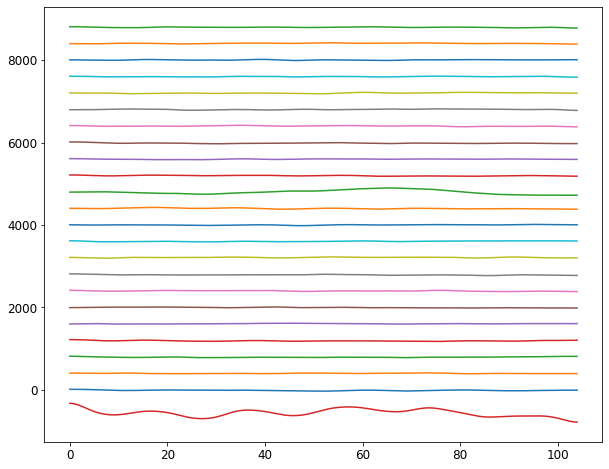

In [28]:
#print(wfm_noise_25)
for i in range(len(wfm_noise_25['X14'])):
    plt.plot(np.arange(waveform_length)*sampling_time,wfm_noise_25['X14'][i] + i*400)
plt.plot(np.arange(waveform_length)*sampling_time,np.sum(wfm_noise_25['X14'],axis=0)-500)
plt.show()